# Prediction the data trend using LTSM Machine learning in AWS SAGEMAKER

In [24]:
#import the data set from the local machine

In [1]:
import pandas as pd

df = pd.read_csv('Data_Tatamotors.csv')

df

,Date,Open,High,Low,Close,Change Percentage,% Change vs Average,Volume,W accumulation,"Pmo(35,20,10)",Stoc Rsi,Price volume change,Rsi
0,2022-11-23,426.10,429.25,423.00,424.15,-0.12,-0.31,"5,14,577",-83.75,0.58,26.39,-107730.72,52.36
1,2022-11-24,423.60,425.30,420.65,423.35,-0.19,-0.38,"6,01,054",-85.70,0.57,22.90,-108864.38,51.76
2,2022-11-25,424.25,435.40,424.25,433.25,2.34,2.14,"6,20,606",-75.80,0.69,60.05,-94351.57,58.19
3,2022-11-28,434.45,440.00,432.40,433.20,-0.01,-0.21,"8,42,444",-82.60,0.79,66.72,-94448.79,58.15
4,2022-11-29,432.90,437.85,429.55,433.05,-0.03,-0.23,"4,02,818",-87.40,0.87,78.51,-94588.27,58.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2023-11-20,683.85,686.70,670.60,674.05,-1.02,-1.22,"4,61,589",-27.35,1.76,77.32,727129.29,63.87
247,2023-11-21,678.65,683.30,674.75,680.95,1.02,0.83,"2,96,198",-20.45,1.88,86.30,730161.36,66.62
248,2023-11-22,684.75,687.35,675.90,681.10,0.02,-0.17,"5,53,593",-15.25,1.98,85.20,730283.30,66.68
249,2023-11-23,682.15,685.90,677.10,679.85,-0.18,-0.38,"3,43,592",-21.30,2.04,79.04,729652.72,65.63


In [2]:
df = df[['Date', 'Close']]

df

,Date,Close
0,2022-11-23,424.15
1,2022-11-24,423.35
2,2022-11-25,433.25
3,2022-11-28,433.20
4,2022-11-29,433.05
...,...,...
246,2023-11-20,674.05
247,2023-11-21,680.95
248,2023-11-22,681.10
249,2023-11-23,679.85


In [3]:
df['Date']

0      2022-11-23
1      2022-11-24
2      2022-11-25
3      2022-11-28
4      2022-11-29
          ...    
246    2023-11-20
247    2023-11-21
248    2023-11-22
249    2023-11-23
250    2023-11-24
Name: Date, Length: 251, dtype: object

In [4]:
#Function to convert string format to datetime format
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [5]:
df

,Date,Close
0,2022-11-23,424.15
1,2022-11-24,423.35
2,2022-11-25,433.25
3,2022-11-28,433.20
4,2022-11-29,433.05
...,...,...
246,2023-11-20,674.05
247,2023-11-21,680.95
248,2023-11-22,681.10
249,2023-11-23,679.85


In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

/tmp/ipykernel_11377/2565755782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(str_to_datetime)


0     2022-11-23
1     2022-11-24
2     2022-11-25
3     2022-11-28
4     2022-11-29
         ...    
246   2023-11-20
247   2023-11-21
248   2023-11-22
249   2023-11-23
250   2023-11-24
Name: Date, Length: 251, dtype: datetime64[ns]

In [7]:
df.index = df.pop('Date')
df

,Close
Date,
2022-11-23,424.15
2022-11-24,423.35
2022-11-25,433.25
2022-11-28,433.20
2022-11-29,433.05
...,...
2023-11-20,674.05
2023-11-21,680.95
2023-11-22,681.10


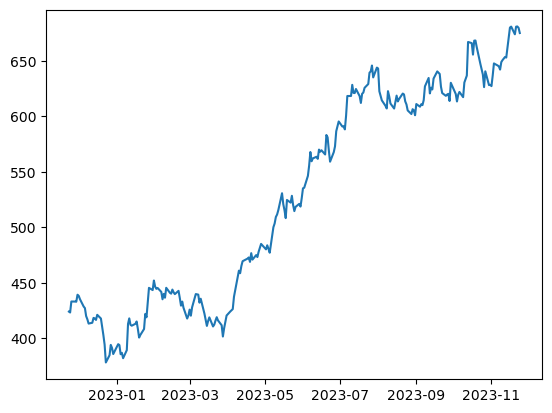

In [8]:
#ANALYSIS OF THE METRICS WITH DATE

import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

# CREATING A FUNCTION TO CREATE THE DATA SET WITH THREE CONSEQUETIVE DATE IN THE BELOW FORMAT
#SAVE THE DATA SET IN THE NEW DATAFRAME
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '2022-11-28',
                                '2023-11-24',
                                n=3)
windowed_df

# GETTING THE SAGEMAKER ARN AND CONFIGURATION
import sagemaker
region =sagemaker.Session().boto_region_name
print("Aws region:{}".format(region))

role=sagemaker.get_execution_role()
print("RoleArn:{}".format(role))

In [11]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((248,), (248, 3, 1), (248,))

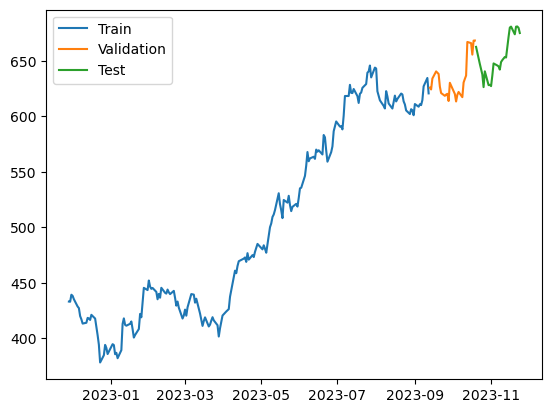

In [12]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

# LTSM ALGORITHM IMPLEMENTATION AND MODEL CREATION
import tensorflow
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

model_dir = '/opt/ml/model'
os.makedirs(model_dir, exist_ok=True)
tf.saved_model.save(model, model_dir)

In [41]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

# Define the SageMaker session and role
sagemaker_session = sagemaker.Session()
role = 'arn:aws:iam::780917416197:role/CFN-SM-IM-Lambda-Catalog-SageMakerExecutionRole-RGNedGui2gbz'

# Define the TensorFlow estimator
estimator = TensorFlow(entry_point='Tatamotors_prediction_.ipynb',
                       role=role,
                       instance_count=1,
                       instance_type='ml.p2.xlarge',  # Choose instance type as needed
                       framework_version='2.4.1',  # TensorFlow version
                       py_version='py37',
                       sagemaker_session=sagemaker_session)

# Start the training job
estimator.fit()


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-11-30-21-01-28-297


Using provided s3_resource


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p2.xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

# ANALYSIS OF THE PREDCITIONS AND OBSERVATIONS
import matplotlib.pyplot as plt

#### Assuming you have already trained your model and have predictions
train_predictions = model.predict(X_train).flatten()

## Save predictions and observations to files
np.savetxt('train_predictions.csv', train_predictions, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')

train_predictions = np.loadtxt('train_predictions.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])
plt.show()


1/1 [==============================] - 0s 20ms/step


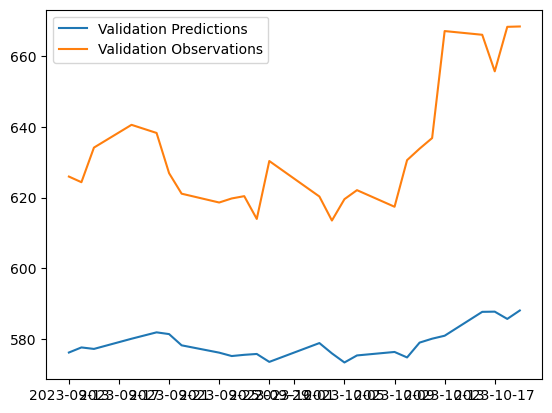

In [28]:
import matplotlib.pyplot as plt

val_predictions = model.predict(X_val).flatten()

# Save predictions and observations to files
np.savetxt('val_predictions.csv', val_predictions, delimiter=',')
np.savetxt('y_val.csv', y_val, delimiter=',')

val_predictions = np.loadtxt('val_predictions.csv', delimiter=',')
y_val = np.loadtxt('y_val.csv', delimiter=',')

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()


1/1 [==============================] - 0s 19ms/step


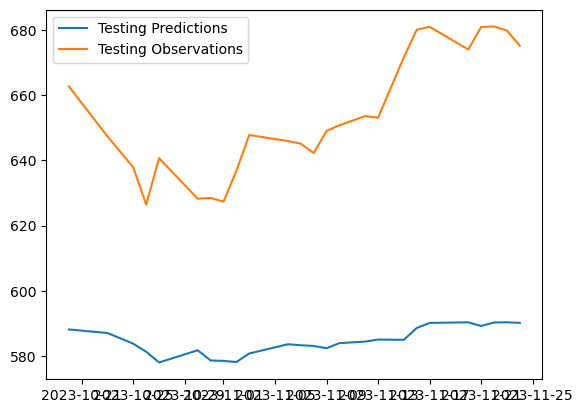

In [29]:


test_predictions = model.predict(X_test).flatten()


np.savetxt('test_predictions.csv', test_predictions, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')


test_predictions = np.loadtxt('test_predictions.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])
plt.show()


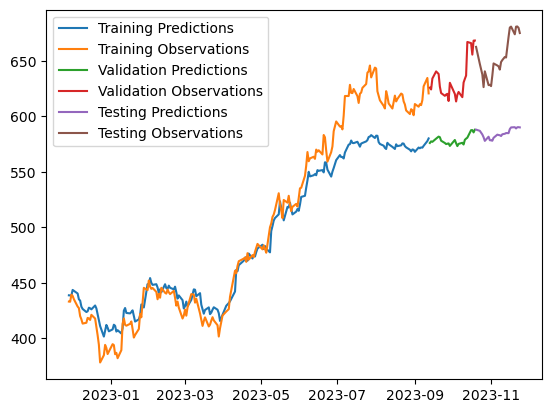

In [30]:


# Assuming you have predictions for train, validation, and test datasets
# Save predictions and observations to files for each dataset
np.savetxt('train_predictions.csv', train_predictions, delimiter=',')
np.savetxt('y_train.csv', y_train, delimiter=',')

np.savetxt('val_predictions.csv', val_predictions, delimiter=',')
np.savetxt('y_val.csv', y_val, delimiter=',')

np.savetxt('test_predictions.csv', test_predictions, delimiter=',')
np.savetxt('y_test.csv', y_test, delimiter=',')

# Remember to download these files from SageMaker to your local machine

# Load the downloaded files from your local directory
train_predictions = np.loadtxt('train_predictions.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

val_predictions = np.loadtxt('val_predictions.csv', delimiter=',')
y_val = np.loadtxt('y_val.csv', delimiter=',')

test_predictions = np.loadtxt('test_predictions.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

# dates_train, dates_val, dates_test contain the respective dates for each dataset
# Plotting the predictions and observations for all datasets on the same plot
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])
plt.show()


# recursive predictions converging to same point after long predictions

1/1 [==============================] - 0s 22ms/step


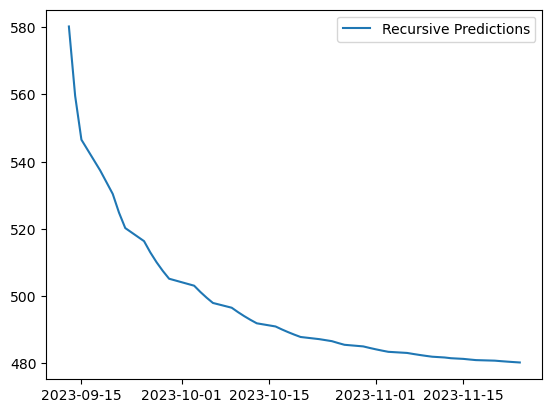

In [43]:
from copy import deepcopy

recursive_predictions = []
last_window = deepcopy(X_train[-1])  # Initialize with the last window from training data

for target_date in recursive_dates:
    next_prediction = model.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction[0])
    
    # Update the last_window for the next prediction
    last_window[:-1] = last_window[1:]  # Shift values to the left
    last_window[-1] = next_prediction  # Update the last value with the prediction

# Plotting the recursive predictions
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Recursive Predictions'])
plt.show()


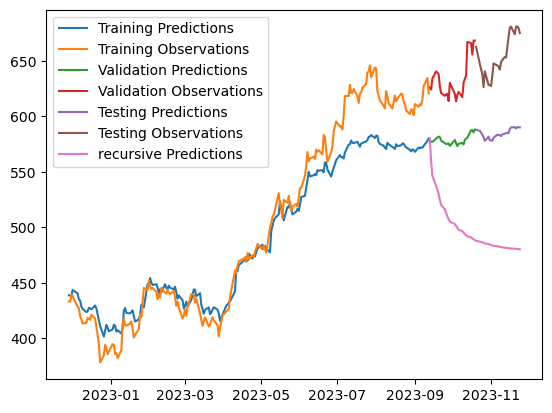

In [40]:
# Assuming you've saved the necessary predictions and observations as files

# Load predictions and observations for train, validation, test, and recursive datasets
train_predictions = np.loadtxt('train_predictions.csv', delimiter=',')
y_train = np.loadtxt('y_train.csv', delimiter=',')

val_predictions = np.loadtxt('val_predictions.csv', delimiter=',')
y_val = np.loadtxt('y_val.csv', delimiter=',')

test_predictions = np.loadtxt('test_predictions.csv', delimiter=',')
y_test = np.loadtxt('y_test.csv', delimiter=',')

# Example of saving predictions to a file
np.savetxt('recursive_predictions.csv', recursive_predictions, delimiter=',')

# Example of loading the file
recursive_predictions = np.loadtxt('recursive_predictions.csv', delimiter=',')

# Plotting all predictions and observations together
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)

plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'recursive Predictions'])

plt.show()


In [55]:
import pandas as pd
import boto3
import sagemaker

excel_file = 'predictions.csv'
data = pd.read_csv(excel_file)


date_column = data['Date']  


data['Open'] = (pd.to_datetime(data['Date']) - pd.to_datetime('11-26-2022')).dt.days

features_for_prediction = data[['Open']]  

predictions = model.predict(features_for_prediction.values)

data['Predicted_Values'] = predictions  
output_file = 'predicted_values.xlsx'
data.to_excel(output_file, index=False)


1/1 [==============================] - 0s 20ms/step
